<a href="https://colab.research.google.com/github/a-mitani/pyro_code_examples/blob/main/pyro_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive


np.random.seed(1)
pyro.set_rng_seed(1)

In [3]:
def create_linear_data(w0=3.0, w1=2.0, sigma=5.0, size=20):
    x = np.random.rand(size) * 10.0
    y = w0 + w1 * x
    y = y + np.random.normal(scale=sigma, size=x.shape[0])
    return x, y

x, y = create_linear_data()
train = torch.tensor(np.array([x, y]).T, dtype=torch.float)

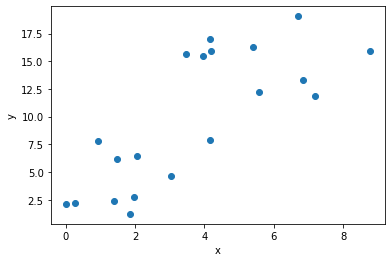

In [4]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x, y)
plt.show()

In [5]:
def model(x, y):
    w0 = pyro.sample("w0", dist.Normal(0., 10.))
    w1 = pyro.sample("w1", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = w0 + w1 * x
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

def guide(x, y):
    w0_loc = pyro.param('w0_loc', torch.tensor(0.))
    w0_scale = pyro.param('w0_scale', torch.tensor(1.), constraint=constraints.positive)
    w1_loc = pyro.param('w1_loc', torch.tensor(0.0))
    w1_scale = pyro.param('w1_scale', torch.tensor(1.0), constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.), constraint=constraints.positive)
    sigma_scale = pyro.param('sigma_scale', torch.tensor(0.5), constraint=constraints.positive)
    w0 = pyro.sample("w0", dist.Normal(w0_loc, w0_scale))
    w1 = pyro.sample("w1", dist.Normal(w1_loc, w1_scale))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, sigma_scale))

Elbo loss: 929.2532387375832
Elbo loss: 62.939687728881836
Elbo loss: 63.404844760894775
Elbo loss: 64.26783490180969
Elbo loss: 64.9003418982029
Elbo loss: 63.357214629650116
Elbo loss: 62.728780180215836
Elbo loss: 73.45997166633606
Elbo loss: 63.512710988521576
Elbo loss: 63.471219301223755


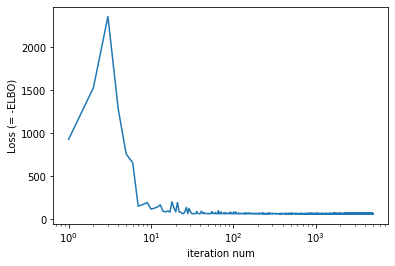

In [6]:
optimizer = pyro.optim.Adam({"lr": .1})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

x, y = train[:, 0], train[:, 1]
pyro.clear_param_store()
num_iters = 5000
iter_nums = []
losses = []
for i in range(num_iters):
    loss = svi.step(x, y)
    iter_nums.append(i + 1)
    losses.append(loss)
    if i % (num_iters / 10) == 0:
        print("Elbo loss: {}".format(loss))

plt.plot(iter_nums, losses)
plt.xscale("log")
plt.xlabel('iteration num')
plt.ylabel('Loss (= -ELBO)')
plt.show()

In [7]:
for name, value in pyro.get_param_store().items():
    print("{} = {:.3f}".format(name, pyro.param(name).item()))

w0_loc = 2.959
w0_scale = 0.840
w1_loc = 1.842
w1_scale = 0.182
sigma_loc = 4.156
sigma_scale = 0.614


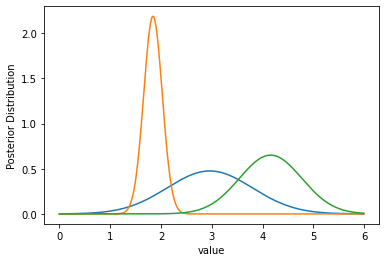

In [8]:
# 得られたパラメータを用いて事後確率分布をプロット
x_range = np.arange(0.0, 6.0, 0.01)

latent_vars = ["w0", "w1", "sigma"]

for latent_var in latent_vars:
    param_loc = latent_var + "_loc"
    param_scale = latent_var + "_scale"
    inferred_dist = dist.Normal(pyro.param(param_loc).item(), pyro.param(param_scale).item())
    inferred_y = [inferred_dist.log_prob(torch.tensor([x])).exp() for x in x_range]
    plt.plot(x_range, inferred_y)

plt.xlabel('value')
plt.ylabel('Posterior Distribution')
plt.show()

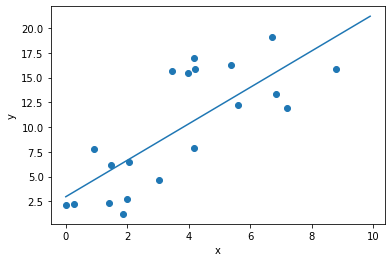

In [9]:
# 潜在変数の平均値でプロット
plt.scatter(x, y)

x_test = np.arange(0, 10, 0.1)
w0_loc = pyro.param("w0_loc").item()
w1_loc = pyro.param("w1_loc").item()
y_test = w0_loc + w1_loc * x_test
plt.plot(x_test, y_test)
plt.xlabel('x')
plt.ylabel('y')

plt.show()


In [10]:
X_range = torch.tensor(np.linspace(0, 10, 50))

predictive = Predictive(model=model, guide=guide, num_samples=1000, return_sites=["w0", "w1", "obs"])
predict_samples = predictive.get_samples(X_range, None)

In [11]:
predict_samples["obs"].shape

torch.Size([1000, 50])

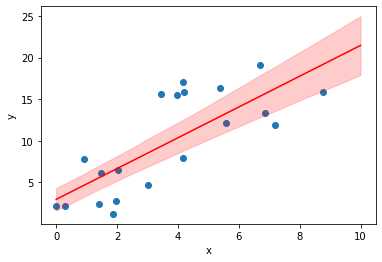

In [12]:
# 回帰直線の90%信頼区間をプロット
sampled_vals = predict_samples["w0"] + predict_samples["w1"] * X_range
mean_vals = sampled_vals.mean(0)
percent05_vals = sampled_vals.kthvalue(int(sampled_vals.shape[0] * 0.05), dim=0)[0]
percent95_vals = sampled_vals.kthvalue(int(sampled_vals.shape[0] * 0.95), dim=0)[0]

plt.scatter(x, y)
plt.plot(X_range, mean_vals, color='r')
plt.fill_between(X_range, percent05_vals, percent95_vals, color='r', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

これは観測誤差が入っていない。観測後さも入れた90%信頼区間を出してみる。

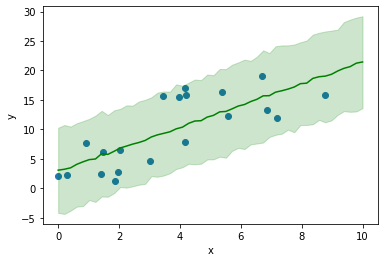

In [13]:
# 観測誤差も考慮したの90%信頼区間をプロット
sampled_vals = predict_samples["obs"]
mean_vals = sampled_vals.mean(0)
percent05_vals = sampled_vals.kthvalue(int(sampled_vals.shape[0] * 0.05), dim=0)[0]
percent95_vals = sampled_vals.kthvalue(int(sampled_vals.shape[0] * 0.95), dim=0)[0]

plt.scatter(x, y)
plt.plot(X_range, mean_vals, color='g')
plt.fill_between(X_range, percent05_vals, percent95_vals, color='g', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()